# COMP551: Project 4

In [0]:
import pandas as pd
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
transform = transforms.Compose([transforms.Resize(32,32),
                               transforms.ToTensor(),
                               #transforms.Lambda(lambda x: x.repeat(3,1,1)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True,num_workers=2)
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False,num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [4]:
#*********************************************************************
# model part
import torchvision.models as models
# use pretrained model:
model = models.squeezenet1_1(pretrained = True)
#import OrderedDicted to corectly align the network layers


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.torch/models/squeezenet1_1-f364aa15.pth
4966400it [00:00, 18944789.18it/s]


In [5]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [0]:
#import nn to modify features
from collections import OrderedDict
from torch import nn
#create classifier which fit our num of outputs

classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 10, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(1)
)
#replace the model's classifier with this new classifier 
model.classifier = classifier
model.forward = lambda x: model.classifier(model.features(x)).view(x.size(0), 10)


In [7]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        #check if the training is correct: print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/100
        
    return epoch_loss, epoch_acc

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
    
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/100
    
    return epoch_loss, epoch_acc

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [12]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
valid_losses=[]
valid_acc =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
# define number of epochs
epochs = 16 
epoch = 0

for e in range(epochs):
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 207.7965  Train Accuracy: 0.2391
Epoch: 1 Validation Loss : 160.6779  Validation Accuracy 0.4260
2
Epoch: 2 Train Loss : 161.7294  Train Accuracy: 0.4025
Epoch: 2 Validation Loss : 137.9431  Validation Accuracy 0.5112
3
Epoch: 3 Train Loss : 144.3542  Train Accuracy: 0.4796
Epoch: 3 Validation Loss : 121.6521  Validation Accuracy 0.5632
4
Epoch: 4 Train Loss : 133.5186  Train Accuracy: 0.5247
Epoch: 4 Validation Loss : 116.2326  Validation Accuracy 0.5830
5
Epoch: 5 Train Loss : 124.3544  Train Accuracy: 0.5628
Epoch: 5 Validation Loss : 110.1547  Validation Accuracy 0.6109
6
Epoch: 6 Train Loss : 117.6292  Train Accuracy: 0.5911
Epoch: 6 Validation Loss : 108.1945  Validation Accuracy 0.6184
7
Epoch: 7 Train Loss : 112.0654  Train Accuracy: 0.6142
Epoch: 7 Validation Loss : 102.2108  Validation Accuracy 0.6405
8
Epoch: 8 Train Loss : 107.0625  Train Accuracy: 0.6315
Epoch: 8 Validation Loss : 99.6780  Validation Accuracy 0.6486
9
Epoch: 9 Train Loss : 103.9771 

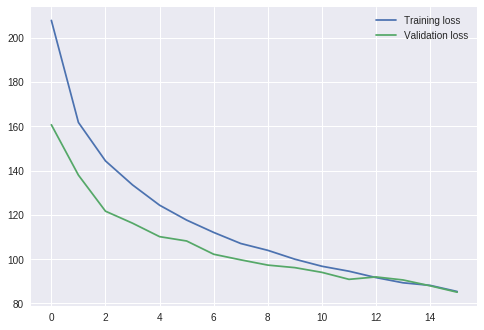

In [13]:
#Plot training and validation losses
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

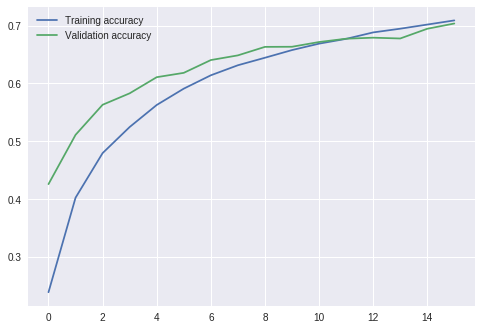

In [14]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [15]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset        loss
  0       1   train  207.796510
  1       2   train  161.729407
  2       3   train  144.354227
  3       4   train  133.518637
  4       5   train  124.354446
  5       6   train  117.629200
  6       7   train  112.065441
  7       8   train  107.062481
  8       9   train  103.977138
  9      10   train   99.976806
  10     11   train   96.789247
  11     12   train   94.549778
  12     13   train   91.673375
  13     14   train   89.317609
  14     15   train   88.151124
  15     16   train   85.389706
  16      1   valid  160.677870
  17      2   valid  137.943137
  18      3   valid  121.652056
  19      4   valid  116.232571
  20      5   valid  110.154682
  21      6   valid  108.194544
  22      7   valid  102.210797
  23      8   valid   99.678032
  24      9   valid   97.308128
  25     10   valid   96.164811
  26     11   valid   94.033627
  27     12   valid   90.882009
  28     13   valid   91.964038
  29     14   valid   90.599931
  30     15   valid   87.959453
  31     16   valid   85.068927,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})